# The goal of this notebook is to implement the work from `molecule_torsion` but then use the tools from `multi_molecule`

In [1]:
import os
import sys
import logging
FORMAT = "%(filename)s:%(lineno)d %(funcName)s %(levelname)s %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

import re
import imp
import itertools
import random
import numpy as np
from numpy import array
import pandas as pd
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns


# do this before we have a chance to import openbabel!
import rdkit, rdkit.Chem.rdDistGeom, rdkit.DistanceGeometry

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import rdBase

import py3Dmol

from rmgpy.molecule import Molecule
from rmgpy.species import Species
from rmgpy.reaction import Reaction


from multi_molecule import *

from ase.calculators.morse import * #chosing this calculator for now because it's fast
from ase.calculators.dftb import *
from ase.calculators.lj import *
from ase.calculators.emt import *
from ase.calculators.eam import *
from ase.calculators.tip3p import *
from ase.calculators.dmol import *
#import hotbit
#from hotbit import *

/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
m = Multi_Molecule("CCOC")
m.view_mol()

In [3]:
# Need to decide which calculator to use... Not sure at this point

"""calc = DMol3(symmetry='auto',
             spin_polarization='unrestricted',
             charge=0,
             basis='dnp',
             pseudopotential='none',
             functional='pbe',
             scf_density_convergence=1.0e-7)"""
calc = EMT()

m.ase_molecule.set_calculator(calc)

In [4]:
tor = m.torsions[0]
i,j,k,l = tor.indices
RHS = tor.RHS
m.ase_molecule.set_dihedral(a1 = i,
                            a2 = j, 
                            a3 = k, 
                            a4 = l, 
                            angle= float(90),
                            indices=RHS)
m.update_geometry_from_ase_mol()
print "The potential energy is: {0}".format(m.ase_molecule.get_potential_energy())
m.view_mol()

The potential energy is: 3.87325473786


In [5]:
# Trying this for two different torsions angles

tor = m.torsions[0]
i,j,k,l = tor.indices
RHS = tor.RHS
m.ase_molecule.set_dihedral(a1 = i,
                            a2 = j, 
                            a3 = k, 
                            a4 = l, 
                            angle= float(0), 
                            indices=RHS)
m.update_geometry_from_ase_mol()
print "The potential energy is: {0}".format(m.ase_molecule.get_potential_energy())

tor = m.torsions[0]
i,j,k,l = tor.indices
RHS = tor.RHS
m.ase_molecule.set_dihedral(a1 = i,
                            a2 = j, 
                            a3 = k, 
                            a4 = l, 
                            angle= float(360), 
                            indices=RHS)
m.update_geometry_from_ase_mol()
print "The potential energy is: {0}".format(m.ase_molecule.get_potential_energy())
m.view_mol()

The potential energy is: 4.18748460383
The potential energy is: 4.18748460383


#### Rotating the total 360 degrees

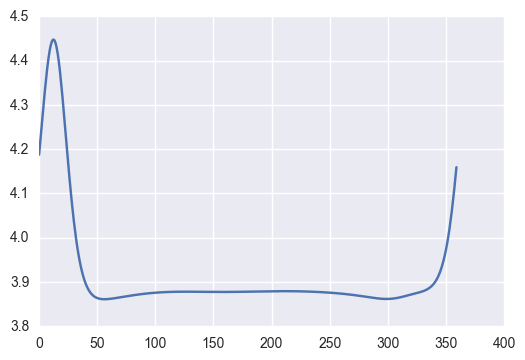

In [6]:
results = []
for q in range(360):
    tor = m.torsions[0]
    i,j,k,l = tor.indices
    RHS = tor.RHS
    m.ase_molecule.set_dihedral(a1 = i,
                                a2 = j, 
                                a3 = k, 
                                a4 = l, 
                                angle= float(q), 
                                indices=RHS)
    m.update_geometry_from_ase_mol()
    results.append((m.ase_molecule.get_potential_energy()))
    
plt.plot(results) 

### Okay, so we're at the point where we can perform calcs on a molecule with a single torsion. Now let's try a molecule with multiple torsions

In [7]:
m = Multi_Molecule("CCCCC")
calc = EMT()
m.ase_molecule.set_calculator(calc)
m.view_mol()

In [8]:
torsion_list = m.torsions
torsion_angles = np.arange(0, 360+10,10)
torsion_combos = list( itertools.combinations_with_replacement( torsion_angles, len(torsion_list)) )
if len(torsion_list) != 1:
    torsion_combos = list(
        set(
            torsion_combos + 
            list(itertools.combinations_with_replacement( 
                torsion_angles[::-1], len(torsion_list)
            ))))
#torsion_list, torsion_combos

In [9]:
results = []
for combo in torsion_combos:
    geo = zip(torsion_list, combo)
    #print geo
    for torsion in geo:
        tor = torsion[0]
        #print tor
        angle = torsion[1]
        
        i,j,k,l = tor.indices
        RHS =  tor.RHS
        m.ase_molecule.set_dihedral(a1 = i,
                                a2 = j, 
                                a3 = k, 
                                a4 = l, 
                                angle= float(angle), 
                                indices=RHS)
    m.update_geometry_from_ase_mol()
    results.append(list(combo) + [np.log10(m.ase_molecule.get_potential_energy())])
results

[[110, 190, 0.77220475449045411],
 [330, 240, 0.78406549443604157],
 [170, 130, 0.77217802726808771],
 [210, 310, 0.77115310095819445],
 [130, 170, 0.77230343744945595],
 [170, 70, 0.77149552460799398],
 [30, 100, 0.77115752716173358],
 [120, 180, 0.77228132105167147],
 [150, 280, 0.77194774462265969],
 [90, 130, 0.77177854779967925],
 [290, 320, 0.77206425605204565],
 [240, 160, 0.77215745892947585],
 [140, 100, 0.77198774895198174],
 [170, 250, 0.77218890747561708],
 [10, 310, 0.89658925774460896],
 [20, 280, 0.77222634283685332],
 [170, 220, 0.77223846316553801],
 [30, 220, 0.77161221800889279],
 [270, 160, 0.77197351330227693],
 [40, 230, 0.77134036536066675],
 [150, 160, 0.77228496279744452],
 [220, 60, 0.77134183774315723],
 [120, 120, 0.77203975018736615],
 [250, 330, 0.77384676921704754],
 [30, 180, 0.77068066902874433],
 [90, 60, 0.77115280765831107],
 [80, 250, 0.77140111750725848],
 [40, 290, 0.78434216297663029],
 [60, 240, 0.77114096582011826],
 [210, 110, 0.77198961214374

In [10]:
df = pd.DataFrame(results)
columns = ["Energy"]
for i in range(len(torsion_list)):
    columns = ["Torsion " + str(i)] + columns

df.columns = columns

df.sort("Energy")

/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Torsion 1  Torsion 0    Energy
828          30         50  0.769078
1113         40         50  0.769295
854          30         60  0.769365
1096         20         60  0.769369
1348         40         40  0.769397
185          20         50  0.769635
360          40         60  0.769667
864          50         50  0.769773
508          10         60  0.769784
942          50        270  0.769846
615          50         40  0.769874
518          40        270  0.769889
464          30         70  0.769931
38           60        280  0.769983
562          70        280  0.770018
278          50         60  0.770020
609          60        270  0.770021
678          40         70  0.770109
1091         20         70  0.770128
1273         40        260  0.770235
1356         30        270  0.770235
1359         60         50  0.770268
190          50        260  0.770285
505          30         40  0.770291
1338         60         60  0.770333
1246         70        270  0.770350
730          50         70  0.770357
32           80        280  0.770382
1009         30         80  0.770456
377          20        160  0.770472
...         ...        ...       ...
1153        360        360  1.437091
1056        360          0  1.437091
567           0        360  1.437091
426           0          0  1.437091
1121         30          0  1.445716
1288         30        360  1.445716
1303         30        320  1.477261
1101        300         30  1.510049
143         310         20  1.514693
965         340         10  1.718196
630         310         40  1.725691
795         350        360  1.732952
503         350          0  1.732952
192         330         20  1.745811
457          20        320  1.780405
1180        320         30  1.802125
279           0        350  1.810230
109         360        350  1.810230
264         340          0  1.826704
112         340        360  1.826704
243         350        350  1.870019
1202        330         10  1.889673
937         300         40  1.907569
1058         20        330  1.917428
1045         10        340  1.954726
791         360        340  2.024671
69            0        340  2.024671
995         320         20  2.082073
303          10        330  2.138816
901         310         30  2.323197

[1369 rows x 3 columns]

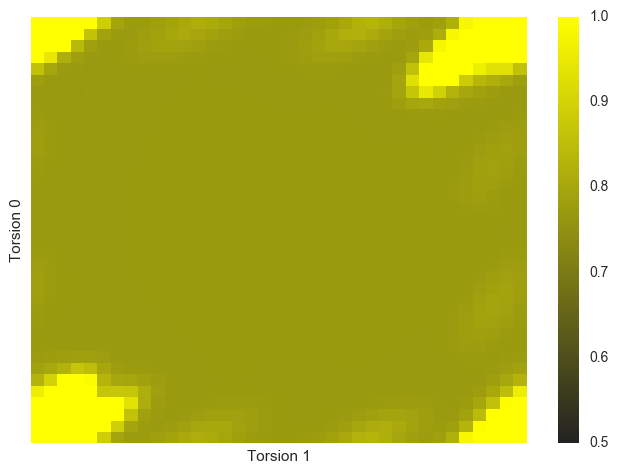

In [11]:
dff = df.pivot(index="Torsion 0", columns="Torsion 1", values="Energy")
sns.set()
sns.heatmap(dff, 
            cmap = sns.dark_palette("yellow", as_cmap=True), 
            vmin =0.5, vmax=1, 
            xticklabels=[], yticklabels=[])

### We should probably be using a nicer calculator. I'm not sure how to address the `clouds` of mildly darker areas

# Now we'll try and make this automatic for molecules

In [12]:
def get_lowest_energy_conformer(multi_molecule):
    """
    A function designed to obtain the lowest energy conformer.
    
    INPUTS:
    * multi_molecule: a `MultiMolecule` object
    * calculator: an `ase.calculator` object
    
    OUTPUT:
    * multi_molecule: a "MultiMolecule` object with the coordinates of the lowest energy conformation 
    """
    torsion_list = multi_molecule.torsions
    torsion_angles = np.arange(0, 360+30,30)
    torsion_combos = list( itertools.combinations_with_replacement( torsion_angles, len(torsion_list)) )
    if len(torsion_list) != 1:
        torsion_combos = list(
            set(
                torsion_combos + 
                list(itertools.combinations_with_replacement( 
                    torsion_angles[::-1], len(torsion_list)
                ))))
        
    results = []
    for combo in torsion_combos:
        geo = zip(torsion_list, combo)
        for torsion in geo:
            tor = torsion[0]
            angle = torsion[1]

            i,j,k,l = tor.indices
            RHS =  tor.RHS
            multi_molecule.ase_molecule.set_dihedral(a1 = i,
                                    a2 = j, 
                                    a3 = k, 
                                    a4 = l, 
                                    angle= float(angle), 
                                    indices=RHS)
        results.append([np.log10(m.ase_molecule.get_potential_energy())] + list(combo))
        
    df = pd.DataFrame(results)
    columns = ["Energy"]
    for i in range(len(torsion_list)):
        columns.append("Torsion " + str(i))

    df.columns = columns

    df.sort("Energy")
    
    lowest_e_torsions = df.loc[:, df.columns != 'Energy'].iloc[0]
    
    for i, dihedral in enumerate(lowest_e_torsions):
        tor = multi_molecule.torsions[i]
        i,j,k,l = tor.indices
        RHS =  tor.RHS
        multi_molecule.ase_molecule.set_dihedral(a1 = i,
                                    a2 = j, 
                                    a3 = k, 
                                    a4 = l, 
                                    angle= float(dihedral), 
                                    indices=RHS)
        
    multi_molecule.update_geometry_from_ase_mol()
    return multi_molecule

In [13]:
calc = EMT()
m.ase_molecule.set_calculator(calc)
m = get_lowest_energy_conformer(m)
m.view_mol()

/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/ipykernel/__main__.py:47: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [14]:
m = Multi_Molecule("C1OCCC1(CCOC)CONC")
m.ase_molecule.set_calculator(calc)
m = get_lowest_energy_conformer(m)
m.view_mol()

/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/ipykernel/__main__.py:47: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


# Ay! We now have a function that works with a `MultiMolecule`

##### Now we just need to address the calculator issue